In [1]:
# Import dependencies
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
STOPWORDS = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [4]:
# File paths
path='./learn-ai-bbc'
train_path=os.path.join(path, 'BBC News Train.csv')
sample_solution_path=os.path.join(path, 'BBC News Sample Solution.csv')

In [5]:
def remove_stopwords(sentence):
    sentence=sentence.lower()

    words=sentence.split()
    no_words=[w for w in words if w not in STOPWORDS]
    sentence=' '.join(no_words)

    return sentence

def parse_data_from_file(filename):
    sentences=[]
    labels=[]

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[2])

            sentence=row[1]
            sentence=remove_stopwords(sentence)
            sentences.append(sentence)
    
    return sentences, labels

In [6]:
sentences, labels=parse_data_from_file(train_path)

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 1490 sentences in the dataset.

First sentence has 203 words (after removing stopwords).

There are 1490 labels in the dataset.

The first 5 labels are ['business', 'business', 'business', 'tech', 'business']


In [7]:
def train_val_split(sentences, labels, training_split):
    train_size=int(len(sentences)*training_split)

    train_sentences=np.array(sentences[:train_size])
    train_labels=np.array(labels[:train_size])

    validation_sentances=np.array(sentences[train_size:])
    validation_labels=np.array(labels[train_size:])

    return train_sentences, train_labels, validation_sentances, validation_labels

In [8]:
train_sentences, train_labels, validation_sentances, validation_labels=train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(validation_sentances)} sentences for validation.\n")
print(f"There are {len(validation_labels)} labels for validation.")

There are 1192 sentences for training.

There are 1192 labels for training.

There are 298 sentences for validation.

There are 298 labels for validation.


In [9]:
def fit_tokenizer(train_sentences, num_words, oov_token):

    tokenizer=Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [10]:
tokenizer=fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_idx=tokenizer.word_index

print(f"Vocabulary contains {len(word_idx)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_idx else "<OOV> token NOT included in vocabulary")

Vocabulary contains 22647 words

<OOV> token included in vocabulary


In [11]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    
    sequences=tokenizer.texts_to_sequences(sentences)
    padded_sequences=pad_sequences(sequences, padding=padding, maxlen=maxlen)

    return padded_sequences

In [12]:
train_padded_sequences=seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
validation_padded_sequences=seq_and_pad(validation_sentances, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_sequences.shape}\n")
print(f"Padded validation sequences have shape: {validation_padded_sequences.shape}")

Padded training sequences have shape: (1192, 120)

Padded validation sequences have shape: (298, 120)


In [13]:
def tokenize_labels(labels, split_labels):
    
    label_tokenizer=Tokenizer()
    label_tokenizer.fit_on_texts(labels)
    label_idx=label_tokenizer.word_index
    label_sequences=label_tokenizer.texts_to_sequences(split_labels)
    label_sequences_array=np.array(label_sequences)-1

    return label_sequences_array, label_idx

In [14]:
train_label_sequences, label_idx=tokenize_labels(labels, train_labels)
validation_label_sequences, label_idx=tokenize_labels(labels, validation_labels)

print(f"Tokenized labels of the training set have shape: {train_label_sequences.shape}\n")
print(f"Tokenized labels of the validation set have shape: {validation_label_sequences.shape}\n")

Tokenized labels of the training set have shape: (1192, 1)

Tokenized labels of the validation set have shape: (298, 1)



In [191]:
def create_model(num_words, embedding_dim, maxlen):

    tf.random.set_seed(123)

    model=tf.keras.models.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [192]:
model=create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history=model.fit(train_padded_sequences, train_label_sequences, epochs=30, validation_data=(validation_padded_sequences, validation_label_sequences))

Epoch 1/30
38/38 [==============================] - 2s 17ms/step - loss: 1.6036 - accuracy: 0.2492 - val_loss: 1.5982 - val_accuracy: 0.2013
Epoch 2/30
38/38 [==============================] - 0s 5ms/step - loss: 1.5857 - accuracy: 0.2399 - val_loss: 1.5763 - val_accuracy: 0.2013
Epoch 3/30
38/38 [==============================] - 0s 5ms/step - loss: 1.5493 - accuracy: 0.3549 - val_loss: 1.5302 - val_accuracy: 0.3624
Epoch 4/30
38/38 [==============================] - 0s 6ms/step - loss: 1.4817 - accuracy: 0.4329 - val_loss: 1.4552 - val_accuracy: 0.3926
Epoch 5/30
38/38 [==============================] - 0s 6ms/step - loss: 1.3737 - accuracy: 0.4815 - val_loss: 1.3388 - val_accuracy: 0.4698
Epoch 6/30
38/38 [==============================] - 0s 7ms/step - loss: 1.2322 - accuracy: 0.5612 - val_loss: 1.1982 - val_accuracy: 0.5872
Epoch 7/30
38/38 [==============================] - 0s 5ms/step - loss: 1.0792 - accuracy: 0.6812 - val_loss: 1.0506 - val_accuracy: 0.7148
Epoch 8/30
38/38 [=

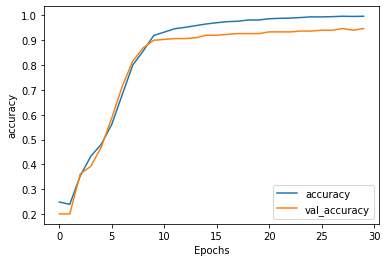

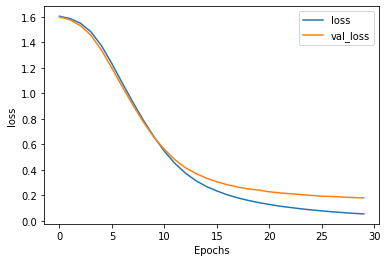

In [193]:
def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])

    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])

    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [15]:
def test_preprocessing(path):
    test_sentences, test_labels=parse_data_from_file(path)
    test_sentences=np.array(test_sentences)
    test_pad_seq=seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)
    test_labels_seq, _ = tokenize_labels(labels, test_labels)

    return test_pad_seq, test_labels_seq, test_sentences

In [16]:
test_pad_seq, test_labels_seq, test_sentences=test_preprocessing(os.path.join(path, 'test1.csv'))

In [17]:
model.evaluate(test_pad_seq,  test_labels_seq)

2/2 [==============================] - 1s 14ms/step - loss: 0.1508 - accuracy: 0.9600


[0.15084847807884216, 0.9599999785423279]

In [18]:
model.save('model.h5')

In [72]:
keys=list(label_idx.keys())
values=list(label_idx.values())
interpreter={}
for i in range(len(values)):
    interpreter[values[i]-1]=keys[i]

print(interpreter)

{0: 'sport', 1: 'business', 2: 'politics', 3: 'entertainment', 4: 'tech'}


In [85]:
def interpretation(prediction):
    new_pred=[]
    for i in range(len(prediction)):
        max_idx= np.where(prediction[i]==np.max(prediction[i]))[0][0]
        new_pred.append([interpreter[max_idx]])
    return new_pred

In [86]:
model=tf.keras.models.load_model('model.h5')
prediction=model.predict(test_pad_seq)
new_pred=interpretation(prediction)
pred_df=pd.DataFrame()
pred_df['Text']=list(test_sentences)
pred_df['Category']=list(new_pred)

pred_df.to_csv(os.path.join(path, 'prediction.csv'))

2/2 [==============================] - 0s 4ms/step
['politics']
['entertainment']
['sport']
['tech']
['politics']
['sport']
['politics']
['tech']
['tech']
['politics']
['politics']
['tech']
['tech']
['entertainment']
['tech']
['entertainment']
['tech']
['sport']
['entertainment']
['business']
['entertainment']
['sport']
['entertainment']
['sport']
['entertainment']
['business']
['entertainment']
['politics']
['tech']
['politics']
['politics']
['entertainment']
['business']
['tech']
['sport']
['sport']
['entertainment']
['politics']
['tech']
['business']
['entertainment']
['entertainment']
['business']
['business']
['sport']
['tech']
['tech']
['business']
['entertainment']
['tech']
[['politics'], ['entertainment'], ['sport'], ['tech'], ['politics'], ['sport'], ['politics'], ['tech'], ['tech'], ['politics'], ['politics'], ['tech'], ['tech'], ['entertainment'], ['tech'], ['entertainment'], ['tech'], ['sport'], ['entertainment'], ['business'], ['entertainment'], ['sport'], ['entertainment'